# Q-learning解决悬崖问题

Q-learning是一个经典的强化学习算法，是一种基于价值(Value-based)的算法，通过维护和更新一个价值表格(Q表格)进行学习和预测。

Q-learning是一种off-policy的策略，也就是说，它的行动策略和Q表格的更新策略是不一样的。

行动时，Q-learning会采用epsilon-greedy的方式尝试多种可能动作。

更新时，Q-learning会采用潜在收益最大化的动作进行价值更新。

总体来说，Q-learning是一个非常勇敢的策略，在有限动作和有限状态情况下，它能够收敛找到全局最优策略。


## 〇，强化学习基本概念

### 1, 环境(env)和智能体(agent)

在第n步，agent处于状态 state(n)中，然后采取行动action(n)，env给agent奖励reward(n+1)，同时agent的状态变成 state(n+1)

```
    ---reward(n+1), state(n+1)-->
env                              agent(state)
    <------ action(n) ----------
```

以我们玩一个俄罗斯方块游戏为例。

环境env就是这个游戏背后的程序，智能体agent就是玩家。

假设现在是第n步，state(n)就是目前游戏所处的状态，可以表示为一个矩阵，也就是游戏界面每个格子的明暗状态。

我们可以采取某个 action(n) (向左，向右，向下，变形)。

然后我们会获得一个奖励reward(n)，即得分。奖励很多时候是稀疏的，即大部分时候为0，操作很多步才有一个不为0的奖励。

同时游戏界面发生变化，状态由 state(n) 变成 state(n+1)。

### 2, 马尔科夫交互链

env和agent交互作用若干个步骤，到达结束状态，通常叫做一个episode(片段)。

s0,a0->r1,s1,a1->r2,s2,a2->...->rn,sn(结束状态)

在俄罗斯方块游戏的例子中，一局完整的游戏构成一个马尔科夫交互链，叫做一个episode.

之所以叫做马尔科夫交互链，是因为这个过程满足马尔科夫假设。

第n+1步骤的状态state(n+1)和奖励reward(n+1)只和第n步骤的状态stage(n)和action(n)有关，而与之前的状态和action无关。

马尔科夫假设要求我们在设计state和action的时候，要考虑到所有相关变量。

并且，只要设计出合理的state变量和action变量，任何游戏都可以表示为这样一个马尔科夫交互链。

### 3, 奖励折现公式

为了衡量每个步骤中action的价值，需要将该步骤之后的奖励，以及未来的全部奖励按照类似金融学中的折现算法求和。

在俄罗斯方块游戏的例子中，一个操作action的价值，不仅跟这个操作完成后立刻获得的奖励reward有关，还要考虑到这个操作的长远影响。

但这种长远影响不太好精确地计算，因为后面获得的奖励，不仅跟当前的action有关，还跟后面的操作有关，所以跟当前操作的相关性是小于1的。

作为简化起见，我们通过类似金融学中现金流折现的方式将未来的奖励全部折算到当前步骤。折算因子gamma一般取值在0.9~1.0之间。


targetQ(n) = reward(n+1) + gamma✖️reward(n+1)+ gamma²✖️reward(n+2)+……

targetQ(n) = reward(n+1) + gamma✖️targetQ(n+1) 

### 4, epsilon-greedy 学习策略

训练时使用epsilon探索，预测时使用greedy贪心。

训练阶段: 以一定epsilon概率选择随机动作，以（1-epsilon）选择最大化Q(s,a)的动作。

预测阶段: 贪心策略，直接选择最大化Q(s,a)的动作。


为了让模型去探索更优策略，我们在训练过程中会允许模型以一定的概率去实施随机动作，以便评估不同动作的价值。

这样也能够让模型对状态动作空间进行更分散的采样，学到的结果也会更加鲁棒。

但在测试过程，为了获得更好的结果，我们应该采用预期价值最大的动作。

### 5, Q表格软更新

targetQ(n) = reward(n+1) + gamma✖️ max(targetQ(n+1),a)  (采用最大化Q的更新策略)

predictQ <- predictQ + learning_rate✖️(targetQ-predictQ)

奖励折现公式对每个action的价值的计算方法是一种粗糙的估计算法。

不同的step或者不同的episode中，按照奖励折现公式对相同state下相同action价值的评估的结果可能差异很大。

为了保持学习过程的稳定性，让Q值不会过分受到某次评估的影响，我们采用一种软更新的方式。

也就是我们在更新Q表格的时候，只让Q值朝着折现公式计算结果靠近一点点(缩小差值)，而不是直接调整为折现公式的计算结果。

这样，我们最终的Q表格中action的价值结果相当是许多次不同episode不同step下奖励折现公式计算结果的某种平均值。

## 一，准备环境

gym是一个常用的强化学习测试环境，可以用make创建环境。

env具有reset,step,render几个方法。


* 悬崖问题

环境设计如下：

环境一共有48个state状态。

其中T为目标位置，到达目标位置游戏结束。

10个用C表示的为悬崖，掉入悬崖会拉回到起始位置。


智能体设计如下：

智能体有4种动作action，0表示往上，1往右，2往下，3往左。


reward设计如下：

智能体每走一步都会有-1的reward。


这个问题希望训练一个能够尽可能快的从起始位置到达目标位置T的智能体Agent。



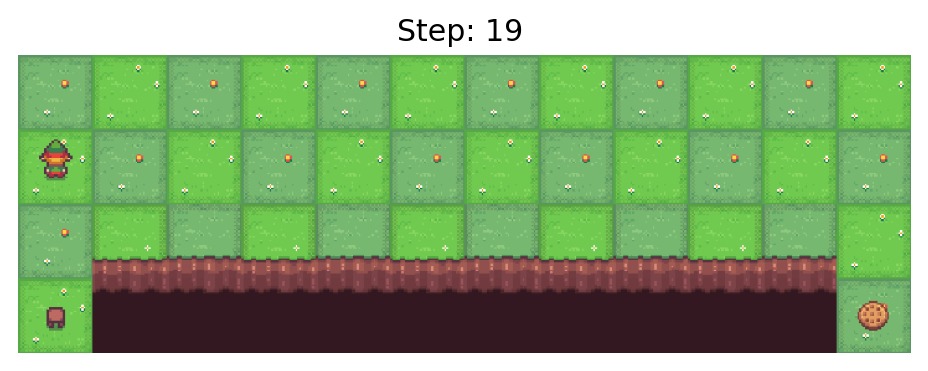

In [1]:
import gym
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

print("gym.__version__=",gym.__version__)


%matplotlib inline

#可视化函数：
def show_state(env, step, info=""):
    plt.figure(num=0,dpi=180)
    plt.clf()
    plt.imshow(env.render())
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    
env = gym.make("CliffWalking-v0",render_mode="rgb_array")  # 0 up, 1 right, 2 down, 3 left
env.reset()

for step in range(20):
    time.sleep(0.2)
    
    action = np.random.randint(0, 4)
    obs, reward, done,truncated, info = env.step(action)
    
    #env.render() 
    show_state(env,step=step)
    #print('step {}: action {}, obs {}, reward {}, done {}, truncated {}, info {}'.format(\
    #        step, action, obs, reward, done, truncated,info))
    
display.clear_output(wait=True)


## 二，定义Agent

In [2]:
import torch 
from torch import nn 

class QAgent(nn.Module):
    def __init__(self, obs_n, act_n, learning_rate=0.01, gamma=0.9, e_greed=0.1):
        super().__init__()
        self.act_n = act_n      # 动作维度，有几个动作可选
        self.lr = learning_rate # 学习率
        self.gamma = gamma      # reward的衰减率
        self.epsilon = e_greed  # 按一定概率随机选动作
        self.Q = nn.Parameter(torch.zeros((obs_n, act_n)),requires_grad=False)

    # 根据输入观察值，采样输出的动作值，带探索
    def sample(self, obs):
        if np.random.uniform(0, 1) < (1.0 - self.epsilon): #根据table的Q值选动作
            action = self.predict(obs)
        else:
            action = np.random.choice(self.act_n) #有一定概率随机探索选取一个动作
        return action
    
    # 根据输入观察值，预测输出的动作值
    def forward(self,obs):
        Q_list = self.Q[obs, :]
        maxQ = Q_list.max()
        action_list = torch.where(Q_list == maxQ)[0].tolist()  # maxQ可能对应多个action
        action = np.random.choice(action_list)
        return action

    
    @torch.no_grad()
    def predict(self,obs):
        self.eval()
        return self.forward(obs)
    

    # 学习方法，也就是更新Q-table的方法
    def learn(self, obs, action, reward, next_obs, done):
        """ on-policy
            obs: 交互前的obs, s_t
            action: 本次交互选择的action, a_t
            reward: 本次动作获得的奖励r
            next_obs: 本次交互后的obs, s_t+1
            next_action: 根据当前Q表格, 针对next_obs会选择的动作, a_t+1
            done: episode是否结束
        """
        predict_Q = self.Q[obs, action]
        if done:
            target_Q = reward # 没有下一个状态了
        else:
            target_Q = reward + self.gamma * self.Q[next_obs, :].max() # Q-learning
        self.Q[obs, action] += self.lr * (target_Q - predict_Q) # 修正q
        
        

In [7]:
# 使用gym创建悬崖环境
env = gym.make("CliffWalking-v0")  # 0 up, 1 right, 2 down, 3 left

# 创建一个agent实例，输入超参数
agent = QAgent(
        obs_n=env.observation_space.n,
        act_n=env.action_space.n,
        learning_rate=0.1,
        gamma=0.9,
        e_greed=0.1)


## 三，训练Agent

下面我们将套用torchkeras的训练模版来对Agent进行训练。

由于强化学习问题与常用的监督学习范式有很大的差异，所以我们对torchkeras的训练模版在

StepRunner, EpochRunner这2个层级上都有少量的修改。


In [8]:
class DataLoader:
    def __init__(self,env,agent,stage='train'):
        self.env = env
        self.agent = agent 
        self.stage = stage
        
    def __iter__(self):

        obs,info = self.env.reset() # 重置环境, 重新开一局（即开始新的一个episode）
        action = self.agent.sample(obs) # 根据算法选择一个动作

        while True:
            next_obs, reward, done, _, _ = self.env.step(action) # 与环境进行一个交互
            if self.stage =='train':
                next_action = self.agent.sample(next_obs) # 训练阶段使用探索-利用策略
            else:
                next_action = self.agent.predict(next_obs) # 验证阶段使用模型预测结果

            yield obs, action, reward, next_obs, done
            action = next_action
            obs = next_obs   

            if done:
                break

dl_train = DataLoader(env,agent,stage='train')
dl_train.size = 1000

dl_val = DataLoader(env,agent,stage='val')
dl_val.size = 200



In [9]:
import sys,datetime
from tqdm import tqdm
import numpy as np

from accelerate import Accelerator
from torchkeras import KerasModel
import pandas as pd 
from torchkeras.utils import is_jupyter,colorful

from copy import deepcopy

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator()
    
    def __call__(self, batch):
        
        obs, action, reward, next_obs, done = batch
        
        #backward()
        if self.stage=="train":
             self.net.learn(obs, action, reward, next_obs, done)
            
        #losses （or plain metric）
        step_losses = {self.stage+'_reward':reward, 
                       self.stage+'_done':1.0 if done else 0.0}
        
        #metrics (stateful metric)
        step_metrics = {}
        if self.stage=='train':
            step_metrics['lr'] = self.net.lr
        return step_losses,step_metrics
    

class EpochRunner:
    def __init__(self,steprunner,quiet=False):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        self.accelerator = steprunner.accelerator
        self.net = steprunner.net
        self.quiet = quiet
        
    def __call__(self,dataloader):
        dataloader.agent = self.net 
        n = dataloader.size  if hasattr(dataloader,'size') else len(dataloader)
        loop = tqdm(enumerate(dataloader,start=1), 
                    total=n,
                    file=sys.stdout,
                    disable=not self.accelerator.is_local_main_process or self.quiet,
                    ncols=100
                   )
        epoch_losses = {}
        for step, batch in loop: 
            step_losses,step_metrics = self.steprunner(batch)   
            step_log = dict(step_losses,**step_metrics)
            for k,v in step_losses.items():
                epoch_losses[k] = epoch_losses.get(k,0.0)+v

            if step_log[self.stage+'_done']<1 and step<n:
                loop.set_postfix(**step_log)



            elif step_log[self.stage+'_done']>0.5 or step==n:
                epoch_metrics = step_metrics
                epoch_metrics.update({self.stage+"_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in self.steprunner.metrics_dict.items()})
                epoch_losses = {k:v for k,v in epoch_losses.items()}
                epoch_log = dict(epoch_losses,**epoch_metrics)
                epoch_log[self.stage+'_step']=step
                loop.set_postfix(**epoch_log)



                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
                loop.close()
            else:
                break
        return epoch_log
    
KerasModel.StepRunner = StepRunner
KerasModel.EpochRunner = EpochRunner 


<<<<<< 🐌 cpu is used >>>>>>


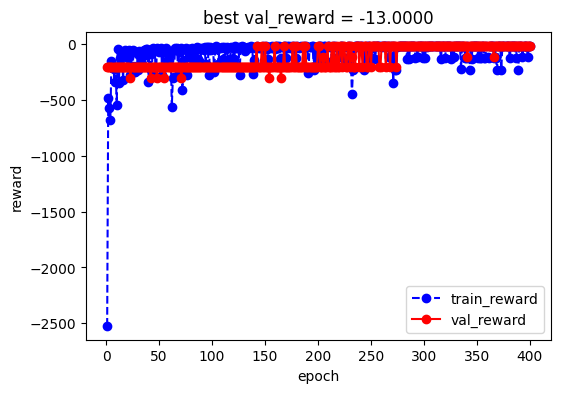

In [10]:
keras_model = KerasModel(net= agent,loss_fn=None)
dfhistory = keras_model.fit(train_data = dl_train,
    val_data=dl_val,
    epochs=400,
    ckpt_path='checkpoint.pt',
    patience=300,
    monitor='val_reward',
    mode='max',
    callbacks=None,
    quiet=True, 
    plot=True,
    cpu=True)


In [ ]:
dfhistory['val_reward'].max() 

In [ ]:
keras_model.load_ckpt('checkpoint.pt')
agent = keras_model.net 


## 四，测试Agent 

In [11]:
def test_agent(env, agent):
    total_reward = 0
    obs,info = env.reset()
    step=0
    while True:
        action = agent.predict(obs) # greedy
        next_obs, reward, done, _ ,_ = env.step(action)
        total_reward += reward
        obs = next_obs
        time.sleep(0.5)
        show_state(env,step)
        step+=1
        if done:
            break
    plt.close()
    return total_reward


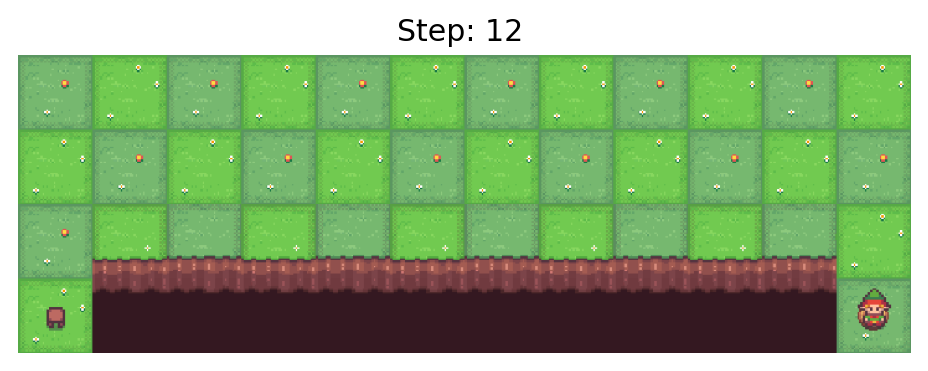

test reward = -13.0


In [17]:
# 全部训练结束，查看算法效果
env = gym.make("CliffWalking-v0",render_mode="rgb_array")  # 0 up, 1 right, 2 down, 3 left
test_reward = test_agent(env, agent)
print('test reward = %.1f' % (test_reward))

## 五，保存Agent 


In [ ]:
torch.save(keras_model.net.state_dict(),'best_ckpt.pt') 
